# Классификация текстов

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

Добавить пункты которые мы пропустили: 

- 1. Посмотрите на токены если будут мусорные добавьте их в стоп слова и обучите заново
- 2. Проверьте повысилось ли качество на стандартных подходах при лемматизации/и без неё
- 3. Удалите/(замените на тег) из текстов сущности(имена, локации, что-то ещё). Запустите классификатор и модельки на сеточках
- 4. Сделайте выводы

In [1]:
import pandas as pd
import numpy as np
import re
import eli5
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from nltk.stem import PorterStemmer, WordNetLemmatizer


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [4]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 66.73%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

In [5]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful', 'outstanding', '10/10', '9/10', \
                 'incredible', 'fantastic', 'awesome', 'superb', 'fabulous', 'perfect',\
                 'brilliant' #@param {type:"raw"} 'gorgeous','advise' 'cool','super'
negative_words = 'worst', '1/10', 'crap', 'delirium', 'idiocy',\
                 'terrible', 'awful', 'disgusting', 'lousy',\
                 'boring', 'waste',  'disappointing', 'lame', 'dreadful' #@param {type:"raw"}'creepy', 'failS','ridiculous'

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))

Test accuracy = 72.32%


**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [6]:
pattern = re.compile('<br\s?\/>|<br>')

print(train_df['review'].iloc[1])
print()
print(pattern.subn(' ', train_df['review'].iloc[1])[0])
print()

This show comes up with interesting locations as fast as the travel channel. It is billed as reality but in actuality it is pure prime time soap opera. It's tries to use exotic locales as a facade to bring people into a phony contest & then proceeds to hook viewers on the contestants soap opera style.<br /><br />It also borrows from an early CBS game show pioneer- Beat The Clock- by inventing situations for its contestants to try & overcome. Then it rewards the winner money. If they can spice it up with a little interaction between the characters, even better. While the game format is in slow motion versus Beat The Clock- the real accomplishment of this series is to escape reality. <br /><br />This show has elements of several types of successful past programs. Reality television, hardly, but if your hooked on the contestants, locale or contest, this is your cup of tea. If your not, this entire series is as I say, drivel dripping with gravy. It is another show hiding behind the reality

Применим ее:

In [7]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

**Подготовка текста**

In [8]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
mystopwords = stopwords.words("english") + ['the', 'a']

def remove_punktuation(text):
    return re.sub(r'[^\w\s\d]', '', text)

def lower_case(text):
    text = str(text).lower()
    return ' '.join(tokenizer.tokenize(text))

def remove_stopwords(text):
    text = tokenizer.tokenize(text)
    text = [w for w in text if w not in mystopwords]
    return ' '.join(text)
    
def normalize(text):
    text = remove_punktuation(text)
    text = lower_case(text)
    text = remove_stopwords(text)
    return text

In [9]:
train_df['review'] = train_df['review'].apply(normalize)
test_df['review'] = test_df['review'].apply(normalize)

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [10]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

Посмотрим на слова, попавшие в словарь:

In [11]:
# vectorizer.get_feature_names()

Попробуем кого-нибудь таки сконвертировать

In [12]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x111517 sparse matrix of type '<class 'numpy.int64'>'
	with 157 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [13]:
vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

Получилось что надо.

Запустим теперь её на реальных данных.

In [14]:
model.fit(train_df['review'], train_df['is_positive'])

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [15]:
def eval_model(model, column):
    preds = model.predict(column)
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df['review'])

Test accuracy = 86.99%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [16]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+2.728,710
+1.689,810
+1.603,refreshing
+1.418,wonderfully
+1.409,funniest
+1.352,erotic
+1.329,excellent
+1.292,carrey
+1.258,flawless
+1.253,hooked


Посмотрим на конкретные примеры его работы:

In [17]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [18]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [19]:
preds_cv = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds_cv != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

In [20]:
incorrect_pred_index_cv = np.where(preds_cv != test_df['is_positive'])

## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [21]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'])

Test accuracy = 88.58%


In [22]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+7.220,great
+6.295,excellent
+5.262,best
+4.709,perfect
+4.676,wonderful
+4.232,amazing
+4.230,well
+4.209,favorite
+4.096,love
+3.857,loved


In [23]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [24]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Примеры неправильной классификации:

In [25]:
preds_tf = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds_tf != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

In [26]:
incorrect_pred_index_tf = np.where(preds_tf != test_df['is_positive'])
incorrect_pred_index_tf

(array([   10,    15,    26, ..., 24973, 24985, 24986], dtype=int64),)

In [27]:
incorrect_pred_index_cv

(array([   10,    13,    15, ..., 24963, 24973, 24986], dtype=int64),)

In [28]:
preds_difference = test_df.copy()
preds_difference['CountVectorizer'] = preds_cv
preds_difference['TfidfVectorizer'] = preds_tf

In [29]:
preds_difference = preds_difference[preds_difference['CountVectorizer'] != preds_difference['TfidfVectorizer']]

In [30]:
preds_difference

,is_positive,review,CountVectorizer,TfidfVectorizer
13,0,interesting period picec showing us amazing 19...,1,0
29,0,really dont know much marquis de sade read boo...,1,0
31,0,astonished major comments ok surf film really ...,1,0
47,1,risky business film lavish production merchant...,0,1
81,1,one better teen comedies filmed 80s valley gir...,0,1
...,...,...,...,...
24930,0,complete nonsense ive studied nazism read many...,1,0
24931,0,eddy murphy robert de niro combination results...,0,1
24938,1,documentary nomadic tribe tibet going dry lake...,0,1
24963,1,going watch film michael caine michael gambon ...,0,1


Tf-idf показывает лучшие результаты. 

1832 текста векторайзеры обработали по-разному.

### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [31]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'])

Test accuracy = 88.28%


In [32]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'])

Test accuracy = 87.55%


In [33]:
vectorizer = TfidfVectorizer(ngram_range=(1, 5))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'])

Test accuracy = 86.62%


### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [34]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'])

Test accuracy = 87.56%


In [35]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [36]:
vectorizer = TfidfVectorizer(ngram_range=(3, 7), analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'])

Test accuracy = 88.33%


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [37]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [38]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

dreamgirls dreamgirl O 
despite despite O 
fistful fistful O 
tony tony O 
wins win O 
incredibly incredibly O 
weak weak O 
year year O 
broadway broadway O 
never never O 
one one O 
would would O 
call call O 
jewel jewel O 
crown crown O 
stage stage O 
musicals musical O 
however however O 
say say O 
right right O 
cinematic cinematic O 
hands hand O 
could could O 
fleshed flesh O 
polished polished O 
something something O 
worthwhile worthwhile O 
onscreen onscreen O 
unfortunately unfortunately O 
transfers transfer O 
screen screen O 
basically basically O 
slavishly slavishly O 
faithful faithful O 
version version O 
stage stage O 
hit hit O 
inherent inherent O 
weaknesses weakness O 
intact intact O 
first first B ORDINAL
score score O 
never never O 
one one B CARDINAL
strong strong O 
points point O 
production production O 
film film O 
change change O 
factor factor O 
lots lot O 
songs song O 
perhaps perhaps O 
many many O 
especially especially O 
memorable memora

Весь этот процесс очень долгий, поэтому я предподсчитал всё.

In [39]:
# import pickle

# with open('train_docs.pkl', 'rb') as f:
#     train_docs = pickle.load(f)
    
# with open('test_docs.pkl', 'rb') as f:
#     test_docs = pickle.load(f)

**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [40]:
lemmatizer = WordNetLemmatizer()

In [41]:
def lemmatized_words(text):
    text_lem = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)]
    return ' '.join(word for word in text_lem)

In [42]:
train_df['lemmatized'] = train_df['review'].apply(lemmatized_words)
test_df['lemmatized'] = test_df['review'].apply(lemmatized_words)

In [43]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['lemmatized'], train_df['is_positive'])

eval_model(model, test_df['lemmatized'])

Test accuracy = 87.97%


**Задание** Попробуйте вместо лемм классифицировать основы.

In [44]:
stemmer = PorterStemmer()

In [45]:
def stemmed_words(text):
    text_stem = [stemmer.stem(word) for word in tokenizer.tokenize(text)]
    return ' '.join(word for word in text_stem)

In [46]:
train_df['stemmed'] = train_df['review'].apply(stemmed_words)
test_df['stemmed'] = test_df['review'].apply(stemmed_words)

In [47]:
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['stemmed'], train_df['is_positive'])

eval_model(model, test_df['stemmed'])

Test accuracy = 88.00%


Стемминг дал чуть более хороший скор.

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [58]:
train_df['review']

0        dreamgirls despite fistful tony wins incredibl...
1        show comes interesting locations fast travel c...
2        simply love movie also love ramones sorta bias...
3        spoilers ahead want call would almost recommen...
4        alltime favorite movie seen many movies one be...
                               ...                        
24995    big fan movie usual reasons think travolta win...
24996    im going bother plot synopsis since know movie...
24997    movie dont know would take indellible characte...
24998    saw film dvd yesterday gobsmacked flabbergaste...
24999    disappointment none nuance original brits seem...
Name: review, Length: 25000, dtype: object

<BarContainer object of 253 artists>

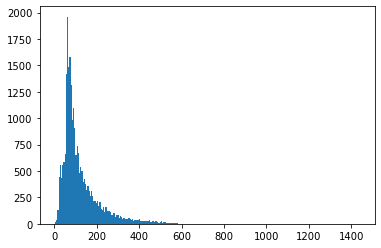

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [60]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 20441


**Задание** Сконвертируйте данные

In [61]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [62]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [63]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [64]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 64)          1308224   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,308,995
Trainable params: 1,308,995
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 7s 31ms/step - loss: 0.5771 - accuracy: 0.7601 - val_loss: 0.3720 - val_accuracy: 0.8544
Epoch 2/10
196/196 [==============================] - 6s 30ms/step - loss: 0.2772 - accuracy: 0.8911 - val_loss: 0.2846 - val_accuracy: 0.8791
Epoch 3/10
196/196 [==============================] - 6s 31ms/step - loss: 0.1750 - accuracy: 0.9345 - val_loss: 0.2819 - val_accuracy: 0.8836
Epoch 4/10
196/196 [==============================] - 6s 31ms/step - loss: 0.1036 - accuracy: 0.9677 - val_loss: 0.3061 - val_accuracy: 0.8791
Epoch 5/10
196/196 [==============================] - 6s 31ms/step - loss: 0.0548 - accuracy: 0.9870 - val_loss: 0.3369 - val_accuracy: 0.8770
Epoch 6/10
196/196 [==============================] - 6s 31ms/step - loss: 0.0250 - accuracy: 0.9961 - val_loss: 0.3748 - val_accuracy: 0.8748
Epoch 7/10
196/196 [==============================] - 6s 30ms/step - loss: 0.0108 - accuracy: 0.9992 - val_loss: 0.4097 - val_accuracy: 0.8730

**Задание** Подсчитайте качество модели на тесте

In [66]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 3s 3ms/step - loss: 0.4828 - accuracy: 0.8714


[0.48281872272491455, 0.871399998664856]

In [70]:
X_train = convert(train_df.lemmatized, word2idx, 1000)
X_test = convert(test_df.lemmatized, word2idx, 1000)

In [72]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 6s 32ms/step - loss: 0.0259 - accuracy: 0.9911 - val_loss: 0.5324 - val_accuracy: 0.8611
Epoch 2/10
196/196 [==============================] - 6s 30ms/step - loss: 0.0045 - accuracy: 0.9996 - val_loss: 0.5665 - val_accuracy: 0.8604
Epoch 3/10
196/196 [==============================] - 6s 30ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.5845 - val_accuracy: 0.8610
Epoch 4/10
196/196 [==============================] - 6s 30ms/step - loss: 6.1712e-04 - accuracy: 1.0000 - val_loss: 0.5984 - val_accuracy: 0.8611
Epoch 5/10
196/196 [==============================] - 6s 30ms/step - loss: 4.4512e-04 - accuracy: 1.0000 - val_loss: 0.6108 - val_accuracy: 0.8614
Epoch 6/10
196/196 [==============================] - 6s 30ms/step - loss: 3.4272e-04 - accuracy: 1.0000 - val_loss: 0.6233 - val_accuracy: 0.8610
Epoch 7/10
196/196 [==============================] - 6s 30ms/step - loss: 2.7278e-04 - accuracy: 1.0000 - val_loss: 0.6344 - val_

In [73]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 3s 3ms/step - loss: 0.6647 - accuracy: 0.8606


[0.6647149920463562, 0.8606399893760681]

In [74]:
X_train = convert(train_df.stemmed, word2idx, 1000)
X_test = convert(test_df.stemmed, word2idx, 1000)

In [75]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 6s 31ms/step - loss: 0.2751 - accuracy: 0.8985 - val_loss: 0.4363 - val_accuracy: 0.8199
Epoch 2/10
196/196 [==============================] - 6s 31ms/step - loss: 0.1107 - accuracy: 0.9626 - val_loss: 0.5605 - val_accuracy: 0.8093
Epoch 3/10
196/196 [==============================] - 6s 31ms/step - loss: 0.0561 - accuracy: 0.9844 - val_loss: 0.6496 - val_accuracy: 0.8025
Epoch 4/10
196/196 [==============================] - 6s 31ms/step - loss: 0.0269 - accuracy: 0.9949 - val_loss: 0.7188 - val_accuracy: 0.8038
Epoch 5/10
196/196 [==============================] - 6s 30ms/step - loss: 0.0122 - accuracy: 0.9992 - val_loss: 0.7823 - val_accuracy: 0.8034
Epoch 6/10
196/196 [==============================] - 6s 30ms/step - loss: 0.0060 - accuracy: 0.9998 - val_loss: 0.8431 - val_accuracy: 0.8029
Epoch 7/10
196/196 [==============================] - 6s 30ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.8830 - val_accuracy: 0.8022

In [76]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 2s 3ms/step - loss: 0.9842 - accuracy: 0.8023


[0.9841704964637756, 0.8023200035095215]

В модели глубокого обучения лучший результат показала сеть на лемматизированных текстах.